# Analysis of Monthly Stress Composites

This notebook will walk through the analysis of stress maps on a monthly timescale over the Shirase Glacier in Antarctica.

## Load in Packages

In [1]:
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr

from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.pyplot as plt

import json
import blue_ice_tools as bit
import itslivetools

## Load in Shapefile, Velocity Data, and compute Stress

As shown at the end of the previous notebook, we have a function that can calculate stresses on all monthly timesteps in a given datacube. <br>
We will load in this data here:

In [2]:
# Read in shapefile of Shirase Glacier
shirase_shape = gpd.read_file('../data/shirase-glacier/shirase.shp')

# Load in ITS_LIVE velocities with shape
shirase_dc = bit.get_data_cube(shape=shirase_shape, epsg=3031)

# Create a list of variable names
vars = ['eps_eff', 'eps_xx', 'eps_yy', 'sigma_vm', 'sigma1', 'sigma2']

# Call stress function, save outputs as new data vars
shirase_dc[vars] = bit.compute_strain_stress(shirase_dc.vx, shirase_dc.vy, rotate=True)
shirase_dc

<xarray.Dataset> Size: 750MB
Dimensions:   (mid_date: 97, y: 655, x: 328)
Coordinates:
  * x         (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y         (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    mapping   int64 8B 0
  * mid_date  (mid_date) datetime64[ns] 776B 2015-01-31 ... 2023-01-31
Data variables:
    v         (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    vx        (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    vy        (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    eps_eff   (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    eps_xx    (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    eps_yy    (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    sigma_vm  (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    sigma1    (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
    sigma2    (mid_date, y, x) float32 83MB dask.array<chunksize=(97, 655, 328), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 13:16:09
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Now that a monthly timeseries of stress has been lazily computed, we can load the full dataset into memory.

The following block will issue a RuntimeWarning from the NaN values in the dataset. This error does not affect the output of the cell, it is simply a warning that trying to run the computations on NaN's will increase the runtime.

To avoid this warning, you can add the command `with np.errstate(divide='ignore',invalid='ignore'):` to silence it for just this cell

In [4]:
with np.errstate(divide='ignore',invalid='ignore'):
    shirase_ds = shirase_dc.compute()

shirase_ds

<xarray.Dataset> Size: 750MB
Dimensions:   (mid_date: 97, y: 655, x: 328)
Coordinates:
  * x         (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y         (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    mapping   int64 8B 0
  * mid_date  (mid_date) datetime64[ns] 776B 2015-01-31 ... 2023-01-31
Data variables:
    v         (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan nan
    vx        (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan nan
    vy        (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan nan
    eps_eff   (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan nan
    eps_xx    (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan nan
    eps_yy    (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan nan
    sigma_vm  (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan nan
    sigma1    (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan nan
    sigma2    (mid_date, y, x) float32 83MB nan nan nan nan ... nan nan nan nan
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 13:16:09
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/S70E030/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## Plot Temporal Average

Let's start by plotting the temporal average of Von Mises stress over Shirase Glacier to look for any interesting areas.
To get an idea of flow speed and direction, I would also like to plot a streamplot next to the stress

In [8]:
# Take temporal average of dataset
time_avg = shirase_ds.mean(dim='mid_date', skipna=True)

# Take x and y componenets of v, calculate magnitude
vx = time_avg.vx
vy = time_avg.vy
vv = np.sqrt((vx ** 2) + (vy ** 2))

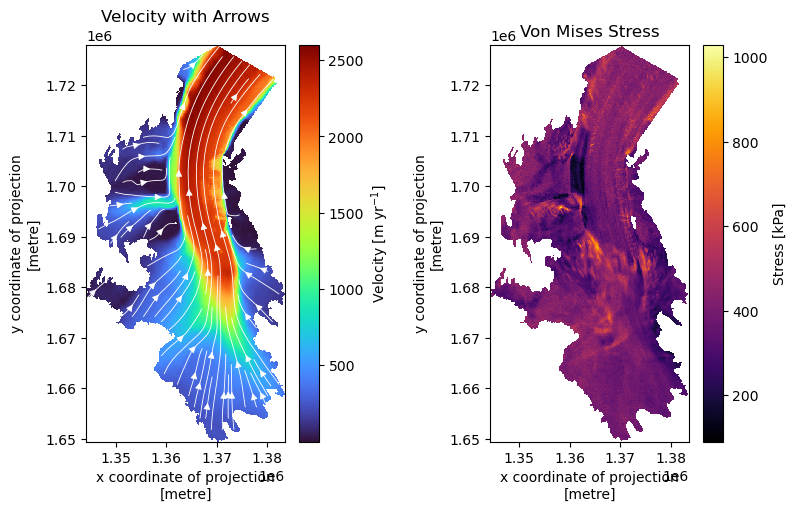

In [15]:
# create a figure with two subplots
fig, axs = plt.subplots(ncols=2, layout='constrained', figsize=(8,5))

# Plot velocity field w/ turbo colormap
vv.plot(ax=axs[0], cmap='turbo', cbar_kwargs={'label':'Velocity [m yr$^{-1}$]'})

# # Account for 'strictly increasing' requirement for streamplots in newer matplotlibs:
# # flip if Y is decreasing rather than increasing. This is only necessary for plotting
# streamplots, not quiverplots.
if vv.y.values[1] - vv.y.values[0] < 0:
    vv_flip = vv.reindex(y = vv.y[::-1])
    vx_flip = vx.reindex(y = vx.y[::-1])
    vy_flip = vy.reindex(y = vy.y[::-1])
else: 
    vv_flip = vv
    vx_flip = vx
    vy_flip = vy


# # Plot flow direction using streamplot
axs[0].streamplot(
    vv_flip.x.values, 
    vv_flip.y.values, 
    vx_flip.values, 
    vy_flip.values,
    color='white',
    linewidth=0.6,
    density=1.2,
)

# Plot Von Mises Stress
c = time_avg.sigma_vm.plot(ax=axs[1], cmap='inferno')
c.colorbar.set_label('Stress [kPa]')

titles = ['Velocity with Arrows', 'Von Mises Stress']
for ax, title in zip(axs, titles):
    ax.set_aspect('equal')
    ax.set_title(title)

plt.show()

There a two areas that may be interesting to look at close up:
- Near `(1.365e6, 1.69e6)`
- Near `(1.363e6, 1.705e6)`

Next, let's look at how the stress changes at and/or around those points over time

## Time Series at Specific Point

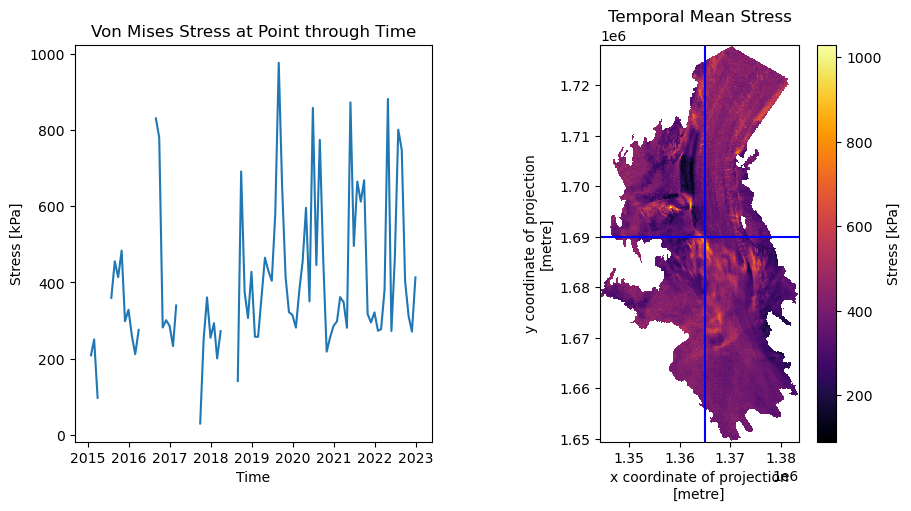

In [33]:
# Save x and y location as variables
x, y = (1.365e6, 1.69e6)

# select nearest point to specified location from main ds
point = shirase_ds.sel(x=x, y=y, method='nearest')

fig, axs = plt.subplots(ncols=2, layout='constrained', figsize=(9,5))

# plot timeseries of Von Mises Stress
point.sigma_vm.plot(ax=axs[0])
axs[0].set_title('Von Mises Stress at Point through Time')
axs[0].set_ylabel('Stress [kPa]')
axs[0].set_xlabel('Time')

# Plot Von Mises Stress
c = time_avg.sigma_vm.plot(ax=axs[1], cmap='inferno')
c.colorbar.set_label('Stress [kPa]')
axs[1].set_title('Temporal Mean Stress')
# Plot verticle and horizontal lines that intersect at point
axs[1].axhline(y=y, c='blue')
axs[1].axvline(x=x, c='blue')
axs[1].set_aspect('equal')

plt.show()

Whoaaaaaa coool. Maybe a seasonal trend? Lets look at the next point!

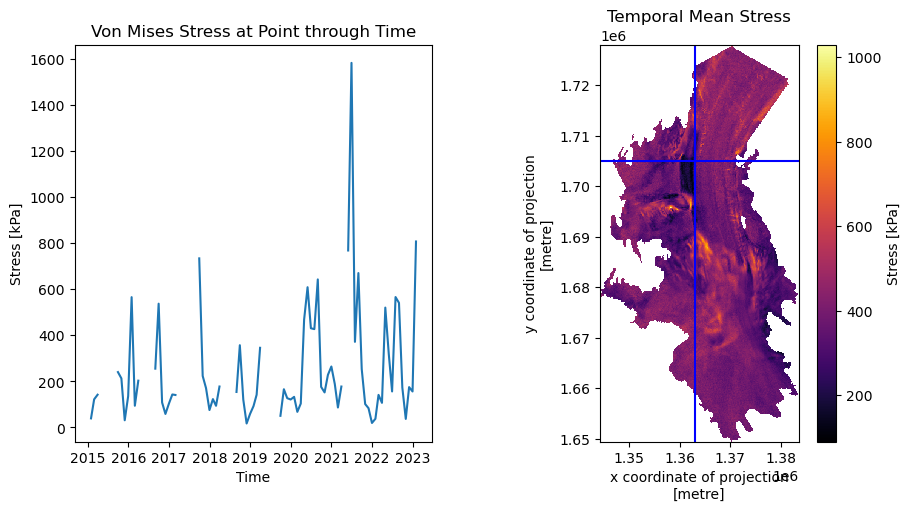

In [40]:
# Save x and y location as variables
x, y = (1.363e6, 1.705e6)

# select nearest point to specified location from main ds
point = shirase_ds.sel(x=x, y=y, method='nearest')

fig, axs = plt.subplots(ncols=2, layout='constrained', figsize=(9,5))

# plot timeseries of Von Mises Stress
point.sigma_vm.plot(ax=axs[0])
axs[0].set_title('Von Mises Stress at Point through Time')
axs[0].set_ylabel('Stress [kPa]')
axs[0].set_xlabel('Time')

# Plot Von Mises Stress
c = time_avg.sigma_vm.plot(ax=axs[1], cmap='inferno')
c.colorbar.set_label('Stress [kPa]')
axs[1].set_title('Temporal Mean Stress')
# Plot verticle and horizontal lines that intersect at point
axs[1].axhline(y=y, c='blue')
axs[1].axvline(x=x, c='blue')
axs[1].set_aspect('equal')

plt.show()

Whoa! Yup , sure looks seasonal to me!

Some VERY high values on the seasonal trend. Most swings are reasonable, the one in 2021, not so much

Let's use the xarray groupby feature to look at a spatio-temporal average of the stress by season

In [41]:
# Use the xarray groupby func to group by season
seasons_gb = shirase_ds.groupby(shirase_ds.mid_date.dt.season).mean(skipna=True)

# reindex the season so that the first to pixels are winter, second two are summer
seasons_gb = seasons_gb.reindex({'season':['MAM', 'JJA', 'SON', 'DJF']})

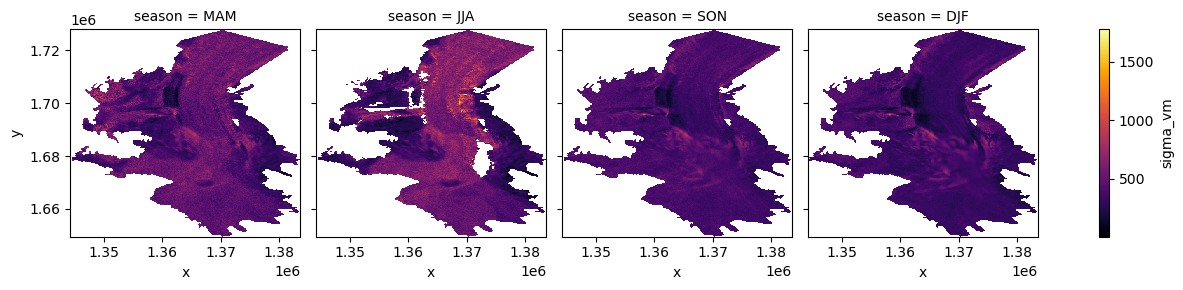

In [42]:
fg = seasons_gb.sigma_vm.plot(col='season', cmap='inferno')

That's pretty cool. The highest stresses are during the hight of Antarctic winter. The data in the winter appears to be much noisier than the summer data.

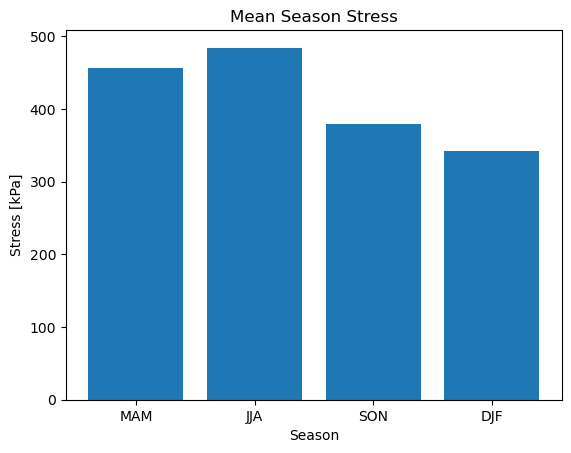

In [47]:
seasonal_stress = seasons_gb.sigma_vm.mean(dim=['x', 'y'])

fig, ax = plt.subplots()

ax.bar(height=seasonal_stress.data, x=seasonal_stress.season.data)
ax.set_ylabel('Stress [kPa]')
ax.set_xlabel('Season')
ax.set_title('Mean Season Stress')

plt.show()

This histogram backs up the previous map numerically

## Conclusion

We have now seen some analysis of the stresses on a timescale, including monthly and seasonal.

In the next notebook, we will look at the time vary stresses in comparison with time varying fracture maps.